# Mall Customers
- Andrea Cohen
- 04.25.2023

## Task:
- To segment the customers based on age, gender, and interest.

## Data Source:
- https://www.kaggle.com/datasets/shwetabh123/mall-customers

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Load and inspect the data

In [2]:
# load the dataset and check for unnecessary columns
df = pd.read_csv('Data/Mall_Customers.csv', index_col = 'CustomerID')
display(df.head())
display(df.info())

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


None

In [3]:
df.shape

(200, 4)

- There are 200 rows and 4 columns.

In [4]:
# check datatypes
df.dtypes

Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

- Genre is datatype object.
- Age, Annual Income (k$), and Spending Score (1-100) are all datatype int64.

In [5]:
# check for outliers and obvious errors
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


- There are no obvious outliers or errors in the data.

In [6]:
# check for duplicated rows
df.duplicated().sum()

0

- There are 0 duplicates.

In [7]:
# check for missing values
df.isna().sum()

Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

- There are 0 missing values.

In [8]:
#check for inconsistencies in categorical data
df['Genre'].value_counts()

Female    112
Male       88
Name: Genre, dtype: int64

- There are no inconsistencies in the categorical data.

## Prepare the data for clustering

### One-Hot Encode the categorical data

In [9]:
#make column selector
cat_selector = make_column_selector(dtype_include = 'object')
#select categorical columns
cat_data = df[cat_selector(df)]
#instantiate one hot encoder
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')
#fit and transform categorical data
df_ohe = ohe.fit_transform(cat_data)
#extract column names
ohe_column_names = ohe.get_feature_names_out(cat_data.columns)
#convert to a dataframe
ohe_df = pd.DataFrame(df_ohe, columns = ohe_column_names)
ohe_df.head()

,Genre_Female,Genre_Male
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


### Scale the numeric data

In [10]:
#make column selector
num_selector = make_column_selector(dtype_include = 'number')
#select numeric columns
num_data = df[num_selector(df)]
#save column names
num_cols = num_selector(df)
#instantiate the standard scaler
scaler = StandardScaler()
#fit and transform numeric data
df_scaled = scaler.fit_transform(num_data)
#convert to a dataframe
scaled_df = pd.DataFrame(df_scaled, columns = num_cols)
scaled_df.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


## Concatenate the transformed dataframes

In [11]:
df_processed = pd.concat([scaled_df, ohe_df], axis=1)
display(df_processed.head())
display(df_processed.info())

,Age,Annual Income (k$),Spending Score (1-100),Genre_Female,Genre_Male
0,-1.424569,-1.738999,-0.434801,0.0,1.0
1,-1.281035,-1.738999,1.195704,0.0,1.0
2,-1.352802,-1.700830,-1.715913,1.0,0.0
3,-1.137502,-1.700830,1.040418,1.0,0.0
4,-0.563369,-1.662660,-0.395980,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Annual Income (k$)      200 non-null    float64
 2   Spending Score (1-100)  200 non-null    float64
 3   Genre_Female            200 non-null    float64
 4   Genre_Male              200 non-null    float64
dtypes: float64(5)
memory usage: 7.9 KB


None

## KMeans Clustering

### Elbow plot of inertia

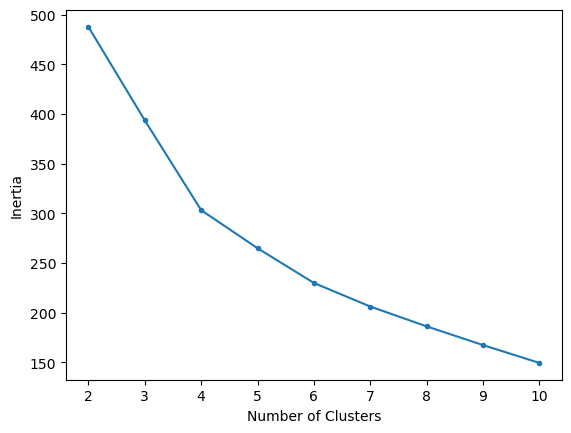

In [12]:
#create an empty list of inertias
inertias = []
#loop through k values between 2 and 10 and store the inertias in the list
for k in range(2, 11):
  kmeans = KMeans(n_clusters = k, random_state=42)
  kmeans.fit(df_processed)
  inertias.append(kmeans.inertia_)
#visualize scores
plt.plot(range(2, 11), inertias, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

- The inertia plot has an elbow at 4 clusters.  4 would be one candidate for a good number of clusters.

### Silhouette scores

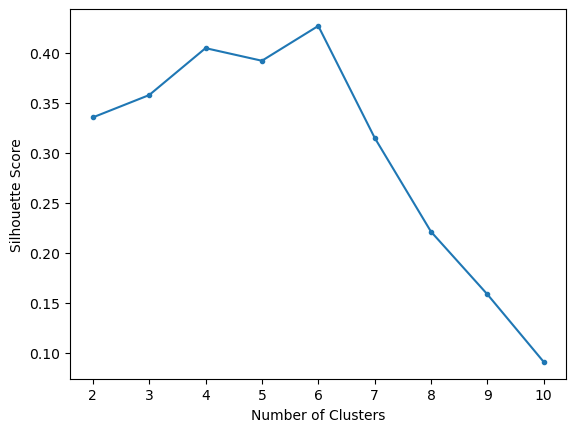

In [13]:
#save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i, random_state=42)
  kmeans.fit(df_processed)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))
#visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

- The graph shows that 6 would be another candidate for a good number of clusters since it has the highest Silhouette Score.  It also shows that 4 has the second highest Silhouette Score.
- Reviewing the elbow plot of inertia, there is no elbow at 6, which confirms that 4 is the best candidate for the number of clusters.
- K = 4 has the second highest silhouette score and a good elbow plot of inertia, making it the best candidate for the number of clusters.

## Save the final KMeans Clustering Model

In [14]:
# instantiate the KMeans model using 4 clusters
kmeans4 = KMeans(n_clusters = 4, random_state=42)
# fit the model
kmeans4.fit(df_processed)
# add the clusters as a new column in the original unscaled data frame
df['cluster'] = kmeans4.labels_
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),cluster
CustomerID,,,,,
1,Male,19,15,39,1
2,Male,21,15,81,1
3,Female,20,16,6,1
4,Female,23,16,77,1
5,Female,31,17,40,1


## Analytical Visualizations

In [15]:
# for descriptive purposes only, ordinally encode the gender column
df['Genre'].replace({'Male': 0, 'Female': 1}, inplace=True) 
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),cluster
CustomerID,,,,,
1,0,19,15,39,1
2,0,21,15,81,1
3,1,20,16,6,1
4,1,23,16,77,1
5,1,31,17,40,1


In [16]:
#group the dataframe by cluster and aggregate by mean values
cluster_groups = df.groupby('cluster', as_index = False).mean()
cluster_groups

,cluster,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,0,0.584615,53.661538,47.600000,40.446154
1,1,0.596491,25.438596,40.000000,60.298246
2,2,0.473684,39.921053,86.684211,18.763158
3,3,0.550000,32.875000,86.100000,81.525000


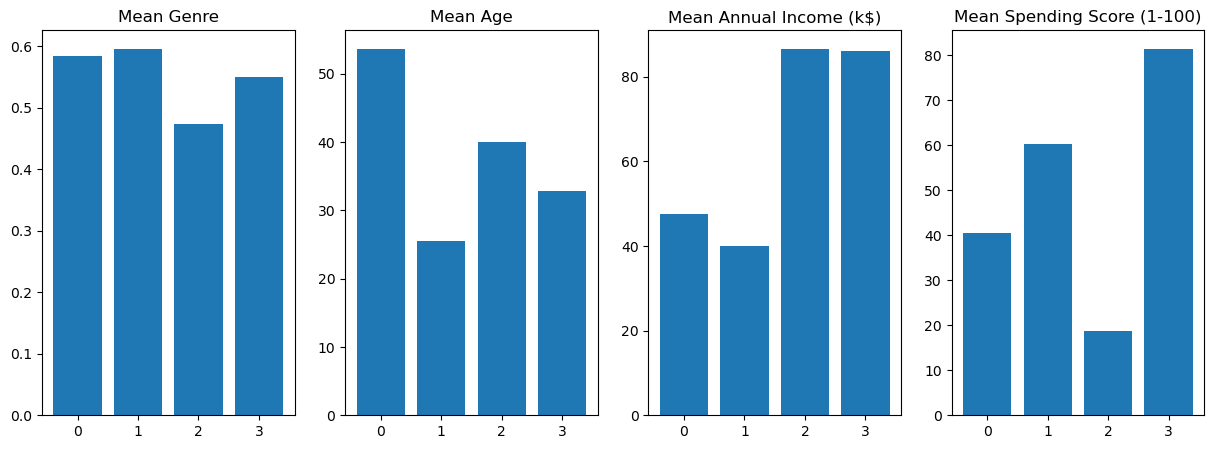

In [17]:
#visualize the means
fig, axes = plt.subplots(1, 4, figsize = (15, 5))
axes = axes.ravel()
#loop over columns (except 'cluster') and plot each in a separate figure
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

## Cluster Descriptions

### Cluster 0:

- Cluster 0 customers were the oldest customers, with low income and low spending scores.  There were more female than male cluster 0 customers.  
- The typical cluster 0 customer was female, 53 years old, made $47600 per year, and had a spending score around 40.  

### Cluster 1:
- Cluster 1 customers were the youngest customers, with the least amount of income, but high spending scores.  There were more female than male cluster 1 customers.
- The typical cluster 1 customer was female, 25 years old, made $40000 per year, and had a spending score around 60.

### Cluster 2:
- Cluster 2 customers were the second oldest customers, with the highest income and the lowest spending scores.  There were more male than female cluster 2 customers.
- The typical cluster 2 customer was male, 40 years old, made $88684 per year, and had a spending score around 19.

### Cluster 3:
- Cluster 3 customers were the second youngest customers, with the second highest income and the highest spending scores.  There were more female than male cluster 3 customers.
- The typical cluster 3 customer was female, 33 years old, made $86100 per year, and had a spending score around 81.